# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [11]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

In [2]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [3]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

11490434/11490434 [==============================] - 0s 0us/step


In [4]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Перший шар, який складається з 128 нейронів
    self.layer1 = DenseLayer(num_features, n_hidden_1, name='layer1')
    # Другий шар, який складається з 256 нейронів
    self.layer2 = DenseLayer(n_hidden_1, n_hidden_2, name='layer2')
    # Вихідний шар
    self.out_layer = DenseLayer(n_hidden_2, num_classes, name='out_layer')


  def __call__(self, x):
    # Передача даних через перші два шари та вихідний шар з функцією активації softmax
    x = self.layer1(x, activation=0)
    x = self.layer2(x, activation=0)
    x = self.out_layer(x, activation=1)
    return x

In [5]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    # Порівнюємо передбачені значення з істинними мітками
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    # Обчислюємо середню точність з використанням згортання
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [6]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(neural_net, input_x, output_y):
  # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активація автоматичного диференціювання
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

    # Отримаємо список оптимізованих параметрів
    trainable_variables = neural_net.trainable_variables

    # Обчислимо за ними значення градієнта
    gradients = g.gradient(loss, trainable_variables)

    # Модифікуємо параметри
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [7]:
# Тренування мережі

loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Оновлюємо ваги нейронної мережі
    train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        loss = cross_entropy(pred, batch_y)
        acc = accuracy(pred, batch_y)
        loss_history.append(loss)
        accuracy_history.append(acc)
        print(f"Крок: {step}, Функція втрат: {loss}, Точність: {acc}")


Крок: 100, Функція втрат: 275.07354736328125, Точність: 0.7109375
Крок: 200, Функція втрат: 202.73532104492188, Точність: 0.75390625
Крок: 300, Функція втрат: 160.6954345703125, Точність: 0.83203125
Крок: 400, Функція втрат: 157.91973876953125, Точність: 0.82421875
Крок: 500, Функція втрат: 131.2617645263672, Точність: 0.84375
Крок: 600, Функція втрат: 136.47744750976562, Точність: 0.83203125
Крок: 700, Функція втрат: 111.04649353027344, Точність: 0.8984375
Крок: 800, Функція втрат: 97.04649353027344, Точність: 0.86328125
Крок: 900, Функція втрат: 142.2203826904297, Точність: 0.85546875
Крок: 1000, Функція втрат: 83.36990356445312, Точність: 0.9140625
Крок: 1100, Функція втрат: 95.7025146484375, Точність: 0.8828125
Крок: 1200, Функція втрат: 92.75122833251953, Точність: 0.90625
Крок: 1300, Функція втрат: 74.54100799560547, Точність: 0.92578125
Крок: 1400, Функція втрат: 92.89799499511719, Точність: 0.890625
Крок: 1500, Функція втрат: 66.49452209472656, Точність: 0.92578125
Крок: 1600, 

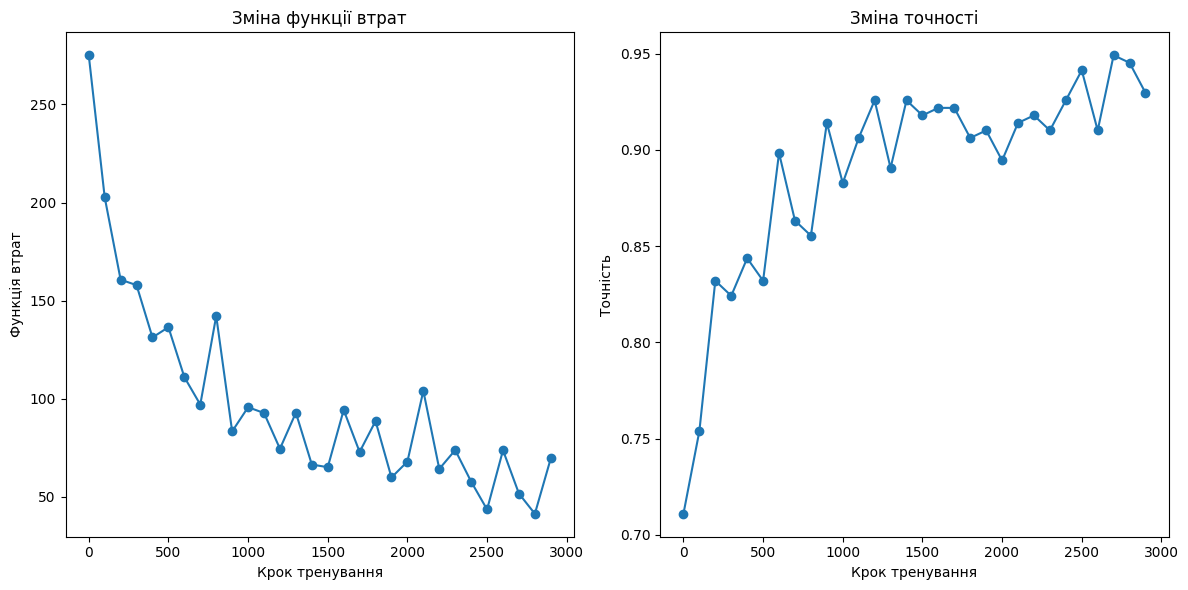

In [8]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

import matplotlib.pyplot as plt

# Виведення графіка функції втрат
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, training_steps + 1, display_step), loss_history, marker='o', linestyle='-')
plt.title('Зміна функції втрат')
plt.xlabel('Крок тренування')
plt.ylabel('Функція втрат')

# Виведення графіка точності
plt.subplot(1, 2, 2)
plt.plot(range(1, training_steps + 1, display_step), accuracy_history, marker='o', linestyle='-')
plt.title('Зміна точності')
plt.xlabel('Крок тренування')
plt.ylabel('Точність')

plt.tight_layout()
plt.show()


In [9]:
# Обчисліть точність навченої нейромережі
# Тестування моделі на тестових даних
test_pred = neural_net(x_test)
accuracy_value = accuracy(test_pred, y_test).numpy()
print(f"Точність на тестовых данних: {accuracy_value * 100:.2f}%")

Точність на тестовых данних: 90.33%


Матриця помилок:
[[ 926    0    5    4    5   18    9    3    5    5]
 [   0 1104    4    4    2    3    3    3   12    0]
 [  10    8  902   38   14    3   11   16   25    5]
 [   2    4    9  918    2   33    4   12   18    8]
 [   1    4    1    0  906    4   12    5    7   42]
 [   6    4    3   53   12  765   16   11   17    5]
 [   9    3    4    1   15   15  896    4   10    1]
 [   0    9   18   12   12    6    0  933    8   30]
 [   6    7   12   34   16   31   11   10  830   17]
 [   6    0    5   16   67   13    2   29   18  853]]
Клас 0: Точність = 0.9586, Повнота = 0.9449, F1 = 0.9517
Клас 1: Точність = 0.9659, Повнота = 0.9727, F1 = 0.9693
Клас 2: Точність = 0.9367, Повнота = 0.8740, F1 = 0.9043
Клас 3: Точність = 0.8500, Повнота = 0.9089, F1 = 0.8785
Клас 4: Точність = 0.8620, Повнота = 0.9226, F1 = 0.8913
Клас 5: Точність = 0.8586, Повнота = 0.8576, F1 = 0.8581
Клас 6: Точність = 0.9295, Повнота = 0.9353, F1 = 0.9324
Клас 7: Точність = 0.9094, Повнота = 0.9076, F1 = 0.9

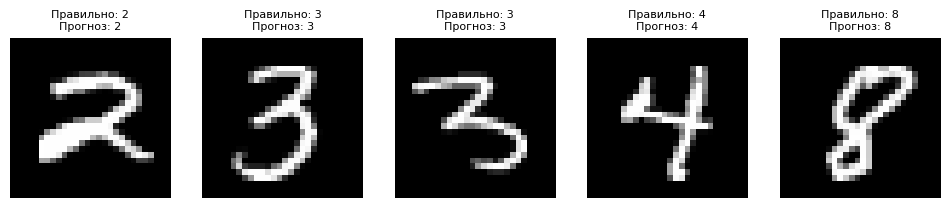

Точність на цих 5 зображеннях: 100.00%


In [12]:
# Протестуйте навчену нейромережу на 10 зображеннях. З тестової вибірки візьміть 5
# випадкових зображень і передайте їх у нейронну мережу.
# Виведіть зображення та випишіть  поруч відповідь нейромережі.
# Зробіть висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?

predicted_labels = tf.argmax(test_pred, axis=1).numpy()
conf_matrix = confusion_matrix(y_test, predicted_labels)
print("Матриця помилок:")
print(conf_matrix)

precision_values = precision_score(y_test, predicted_labels, average=None)
recall_values = recall_score(y_test, predicted_labels, average=None)
f1_values = f1_score(y_test, predicted_labels, average=None)

for i in range(num_classes):
    print(f"Клас {i}: Точність = {precision_values[i]:.4f}, Повнота = {recall_values[i]:.4f}, F1 = {f1_values[i]:.4f}")


import random

# Виберемо 5 випадкових зображень з тестової вибірки
random_indices = np.random.choice(len(x_test), 5, replace=False)
test_images = x_test[random_indices]
test_labels = y_test[random_indices]

# Прогнозуємо класи для вибраних зображень
predictions = neural_net(test_images)
predicted_labels = tf.argmax(predictions, axis=1).numpy()

# Виведемо зображення та випишемо поруч відповідь нейромережі
plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(test_images[i].reshape((28, 28)), cmap='gray')
    plt.title(f"Правильно: {test_labels[i]}\nПрогноз: {predicted_labels[i]}", fontsize = 8)
    plt.axis('off')

plt.show()

# Порівняємо прогнози з правильними мітками та обчислимо точність
correct_predictions = (predicted_labels == test_labels)
accuracy = sum(correct_predictions) / len(correct_predictions)
print(f"Точність на цих 5 зображеннях: {accuracy * 100:.2f}%")




На основі результатів на тренувальних данних модель справилась непогано, так як точність за 3000 епох = 0,9, що є хорошим показником для моделі tensorflow. З тестовими данними модель справилась бездоганно так як було відгадано 100% тестових зображень.
